# Spark MLlib: Preprocesamiento de Datos

## Omar Gaston - oy-gastonc@javeriana.edu.co

#### Pontificia Universidad Javeriana (PUJ) | *Computacion de alto redimiento* 

Este cuaderno muestra cómo:

1. Identificar y rellenar valores faltantes
2. Eliminar duplicados
3. Eliminar columnas que no aportan valor
4. Realizar operaciones Pivot y Explode
5. Normalizar datos

**Dataset**: Titanic Dataset (pasajeros del Titanic con valores faltantes, duplicados y columnas innecesarias)

**Objetivo**: Limpiar y transformar datos para análisis de supervivencia

---

## Contexto del Problema

### El Desastre del Titanic

Este dataset contiene información sobre 891 pasajeros y representa uno de los casos de estudio más emblemáticos en ciencia de datos.

### ¿Por qué necesitamos el preprocesamiento?

Los datos del mundo real **nunca** están limpios. En el caso del Titanic:
- **~20% de las edades** están faltantes (muchos pasajeros no registraron su edad)
- **~77% de las cabinas** no tienen registro (pasajeros de tercera clase rara vez tenían cabina asignada)
- Existen **registros duplicados** por errores administrativos de la época
- Algunas columnas como `Name` y `Ticket` tienen **formatos inconsistentes**

### Objetivo

Transformar datos crudos y desordenados en un dataset limpio y estructurad.

---

## 2. Marco Teórico

### 2.1 Preprocesamiento de Datos

Es el conjunto de técnicas aplicadas para limpiar, transformar y estructurar los datos antes de su análisis o modelado:

- Manejo de valores faltantes
- Eliminación de duplicados
- Transformación de estructuras
- Normalización de variables

Su objetivo es garantizar que los datos sean consistentes, comparables y utilizables por algoritmos de análisis y aprendizaje automático.

### 2.2 Apache Spark MLlib

Apache Spark MLlib es la biblioteca de aprendizaje automático escalable de Spark.

### 2.3 Referencias Teóricas

1. Han, J., Kamber, M., & Pei, J. (2012). Data Mining: Concepts and Techniques. Morgan Kaufmann.

2. Zaharia et al. (2016). Apache Spark: The Definitive Guide. O’Reilly Media.


---

## 3. Configuración del Entorno

### 3.1 Requisitos del Sistema

| Componente | Requisito |
|------------|-----------|
| **Python** | >= 3.8 |
| **Apache Spark** | >= 3.0.0 |
| **Memoria RAM** | >= 4 GB |
| **CPU Cores** | >= 4 cores (recomendado) |
| **Sistema Operativo** | Linux |

### 3.2 Dependencias

Instalamos los paquetes necesarios, agregando `%%capture` para no mostrar el output en el notebook. Luego ignoramos los `warning` emitidos por python y finalmente inicializamos spark.

In [1]:
!pip install findspark

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Bibliotecas de PySpark MLlib y la inicializacion para la sesion.

import findspark
findspark.init()
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

### 3.1. Iniciar la sesión de Spark Session

Para este cuaderno utilizaremos una configuracion de spark que nos permita utilizar hacer una ejecucion optima para este experimento.

In [4]:
# Importar librerias necesarias
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, ArrayType
from pyspark.ml.feature import VectorAssembler, StandardScaler, MinMaxScaler
from pyspark.ml.stat import Correlation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sparkConf = (
    SparkConf()
        .set("spark.scheduler.mode", "FAIR")
        .set("spark.shuffle.io.maxRetries", "10")
        .set("spark.shuffle.io.retryWait", "60s") 
        .set("spark.cores.max", "2")
        .set("spark.driver.memory", "2g")
        .set("spark.network.timeout", "600s") 
        .set("spark.driver.host", "10.43.100.120")
        .set("spark.driver.bindAddress", "0.0.0.0")
        .set("spark.driver.port", "36843")
        .set("spark.blockManager.port", "37000")
        .set("spark.executor.extraClassPath", "/opt/spark/jars/*")
        .set("spark.executor.heartbeatInterval", "60s")
        .setMaster("spark://10.43.100.121:7077")
)


# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Omar MLlib Preprocesamiento") \
    .config(conf=sparkConf) \
    .getOrCreate()

SQLContext(sparkContext=spark.sparkContext, sparkSession=spark)

print(f"Spark Version: {spark.version}")
print("Spark Session creada exitosamente!")

# Ocultar warnings
spark.sparkContext.setLogLevel("ERROR")

Spark Version: 3.5.2
Spark Session creada exitosamente!


---

## 4. Cargar y explorar el Dataset


In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType
from pyspark.sql import functions as F
import os, shutil
import urllib.request


# url = "https://raw.githubusercontent.com/datasciencedojo/datasets/refs/heads/master/titanic.csv"
local_path = "/nfs/condor/titanic-dataset.csv"

print("Descargando dataset...")
# urllib.request.urlretrieve(url, local_path)
print("Descarga completa!")

# Leer CSV
df = spark.read.csv(
    local_path,
    header=True,
    inferSchema=True
)

df = df.repartition(2)  # Solo 2 particiones para dataset pequeño

# 2. Cachear en memoria (evita re-lectura y shuffles)
df = df.cache()
df.count()

# Crear una columna de array de cabinas para demostrar explode
# Simulamos que algunos pasajeros tienen múltiples cabinas reservadas
df = df.withColumn(
    "Cabins",
    F.when(F.col("Cabin").isNotNull(), F.split(F.col("Cabin"), " ")).otherwise(F.array())
)

# Añadir algunos duplicados intencionalmente para demostrar la eliminación
duplicate_rows = df.limit(3)
df = df.union(duplicate_rows)

print("\nDataset Titanic cargado exitosamente!")
print(f"Total de registros: {df.count()}")
print(f"\nSchema:")
df.printSchema()

Descargando dataset...
Descarga completa!

Dataset Titanic cargado exitosamente!
Total de registros: 894

Schema:
root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)
 |-- Cabins: array (nullable = true)
 |    |-- element: string (containsNull = false)



In [17]:
# Mostrar el dataset completo
print("Dataset original (con problemas de calidad):")
df.show(15, truncate=False)

Dataset original (con problemas de calidad):
+-----------+--------+------+-------------------------------------------------+------+----+-----+-----+------------------+-------+-----+--------+------+
|PassengerId|Survived|Pclass|Name                                             |Sex   |Age |SibSp|Parch|Ticket            |Fare   |Cabin|Embarked|Cabins|
+-----------+--------+------+-------------------------------------------------+------+----+-----+-----+------------------+-------+-----+--------+------+
|432        |1       |3     |Thorneycroft, Mrs. Percival (Florence Kate White)|female|NULL|1    |0    |376564            |16.1   |NULL |S       |[]    |
|378        |0       |1     |Widener, Mr. Harry Elkins                        |male  |27.0|0    |2    |113503            |211.5  |C82  |C       |[C82] |
|240        |0       |2     |Hunt, Mr. George Henry                           |male  |33.0|0    |0    |SCO/W 1585        |12.275 |NULL |S       |[]    |
|101        |0       |3     |Petranec

In [46]:
## Resumen estadístico inicial
print("Resumen estadístico del dataset original:")
df.summary()

Resumen estadístico del dataset original:


DataFrame[summary: string, PassengerId: string, Survived: string, Pclass: string, Name: string, Sex: string, Age: string, SibSp: string, Parch: string, Ticket: string, Fare: string, Cabin: string, Embarked: string]

## Flujo de Preprocesamiento

```
Dataset crudo
   ↓
Inspección inicial (schema, tipos, valores nulos)
   ↓
Manejo de valores faltantes
   - Age → mediana
   - Fare → media
   - Embarked → moda
   - Cabin → "Unknown"
   ↓
Eliminación de duplicados
   - Registros completos
   - PassengerId
   ↓
Eliminación de columnas irrelevantes
   - Name
   - Ticket
   - Cabin original
   - PassengerId
   ↓
Transformaciones estructurales
   - explode(Cabin)
   - pivot(Clase / Sexo / Puerto)
   ↓
Vectorización
   - VectorAssembler(features_raw)
   ↓
Normalización
   - StandardScaler
   - MinMaxScaler
   ↓
Datas

```et limpio y listo para modeladoaset limpio y listo para modeladot limpio y listo para modelado
                |
+----------------------------+


## 5. Paso 1: Identificar y Rellenar Valores Faltantes

### 5.1 Identificar valores faltantes

#### Análisis de Valores Faltantes

**Interpretación de los resultados:**

| Columna | % Nulos | Estrategia Recomendada | Justificación |
|---------|---------|------------------------|---------------|
| `Age` | ~20% | Mediana | Distribución sesgada, debido a los pasajeros reportados la mediana puede ser mejor opcion que la  media |
| `Cabin` | ~77% | Valor categórico "Unknown" | Demasiados faltantes para imputar; el hecho de NO tener cabina es información valiosa |
| `Embarked` | ~0.2% | Moda | Solo 2 valores faltantes, imputar con el puerto más común (Southampton) |

In [19]:
# Contar valores nulos por columna
print("Valores nulos por columna:")
print("=" * 50)

null_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts.show()

# Calcular porcentaje de valores nulos
total_rows = df.count()
print(f"\nPorcentaje de valores nulos por columna:")
for col_name in df.columns:
    null_count = df.filter(F.col(col_name).isNull()).count()
    null_percentage = (null_count / total_rows) * 100
    print(f"{col_name}: {null_percentage:.2f}% ({null_count}/{total_rows})")

Valores nulos por columna:
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|Cabins|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+------+
|          0|       0|     0|   0|  0|178|    0|    0|     0|   0|  689|       2|     0|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+------+


Porcentaje de valores nulos por columna:
PassengerId: 0.00% (0/894)
Survived: 0.00% (0/894)
Pclass: 0.00% (0/894)
Name: 0.00% (0/894)
Sex: 0.00% (0/894)
Age: 19.91% (178/894)
SibSp: 0.00% (0/894)
Parch: 0.00% (0/894)
Ticket: 0.00% (0/894)
Fare: 0.00% (0/894)
Cabin: 77.07% (689/894)
Embarked: 0.22% (2/894)
Cabins: 0.00% (0/894)


### 5.2 Rellenar valores faltantes

In [20]:
# Estrategia de relleno según tipo de dato:
# - Numéricos: mediana o media
# - Categóricos: moda o valor por defecto
# - Arrays: lista vacía

# Calcular mediana de Age
age_median = df.approxQuantile("Age", [0.5], 0.01)[0]
print(f"Mediana de Age: {age_median}")

# Calcular media de Fare
fare_mean = df.select(F.mean("Fare")).collect()[0][0]
print(f"Media de Fare: {fare_mean:.2f}")

# Obtener moda de Embarked
embarked_mode = df.groupBy("Embarked").count().orderBy(F.desc("count")).first()
if embarked_mode is not None:
    embarked_mode = embarked_mode[0]
else:
    embarked_mode = "S"  # Southampton por defecto
print(f"Moda de Embarked: {embarked_mode}")

print("\n" + "=" * 50)
print("Aplicando estrategias de relleno...")
print("=" * 50)

Mediana de Age: 28.0
Media de Fare: 32.36
Moda de Embarked: S

Aplicando estrategias de relleno...


In [21]:
# Aplicar relleno de valores faltantes
df_filled = df \
    .fillna({"Age": age_median}) \
    .fillna({"Fare": fare_mean}) \
    .fillna({"Embarked": embarked_mode}) \
    .fillna({"Cabin": "Unknown"})

# Rellenar arrays nulos con arrays vacíos
df_filled = df_filled.withColumn(
    "Cabins",
    F.when(F.size(F.col("Cabins")) == 0, F.array(F.lit("Unknown"))).otherwise(F.col("Cabins"))
)

print("Valores faltantes rellenados!")
print("\nDataset después de rellenar valores:")
df_filled.show(15, truncate=False)

Valores faltantes rellenados!

Dataset después de rellenar valores:
+-----------+--------+------+-------------------------------------------------+------+----+-----+-----+------------------+-------+-------+--------+---------+
|PassengerId|Survived|Pclass|Name                                             |Sex   |Age |SibSp|Parch|Ticket            |Fare   |Cabin  |Embarked|Cabins   |
+-----------+--------+------+-------------------------------------------------+------+----+-----+-----+------------------+-------+-------+--------+---------+
|432        |1       |3     |Thorneycroft, Mrs. Percival (Florence Kate White)|female|28.0|1    |0    |376564            |16.1   |Unknown|S       |[Unknown]|
|378        |0       |1     |Widener, Mr. Harry Elkins                        |male  |27.0|0    |2    |113503            |211.5  |C82    |C       |[C82]    |
|240        |0       |2     |Hunt, Mr. George Henry                           |male  |33.0|0    |0    |SCO/W 1585        |12.275 |Unknown|S   

In [22]:
# Verificar que no quedan valores nulos
print("Verificación de valores nulos después del relleno:")
null_counts_after = df_filled.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_filled.columns])
null_counts_after.show()

Verificación de valores nulos después del relleno:
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|Cabins|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+------+
|          0|       0|     0|   0|  0|  0|    0|    0|     0|   0|    0|       0|     0|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+------+



## 6. Paso 2: Eliminar Duplicados

### Análisis de Duplicados

**¿Por qué existen duplicados?**

En datasets históricos como el del Titanic, los duplicados pueden surgir por errores en la transcripcion o familiares con datos identicos.

**Estrategias de eliminación:**
- `dropDuplicates()`: Elimina filas 100% idénticas
- `dropDuplicates(["PassengerId"])`: Mantiene solo un registro por pasajero único

**OJO**: En producción, siempre verificar manualmente los duplicados antes de eliminarlos y mas cuando se trata de un dataset tan pequeno.

In [23]:
# Identificar duplicados
print(f"Registros antes de eliminar duplicados: {df_filled.count()}")

# Contar duplicados completos
duplicates = df_filled.groupBy(df_filled.columns).count().filter(F.col("count") > 1)
num_duplicates = duplicates.count()
print(f"Número de registros duplicados: {num_duplicates}")

if num_duplicates > 0:
    print("\nRegistros duplicados encontrados:")
    duplicates.show(truncate=False)

Registros antes de eliminar duplicados: 894
Número de registros duplicados: 3

Registros duplicados encontrados:
+-----------+--------+------+-------------------------------------------------+------+----+-----+-----+----------+------+-------+--------+---------+-----+
|PassengerId|Survived|Pclass|Name                                             |Sex   |Age |SibSp|Parch|Ticket    |Fare  |Cabin  |Embarked|Cabins   |count|
+-----------+--------+------+-------------------------------------------------+------+----+-----+-----+----------+------+-------+--------+---------+-----+
|240        |0       |2     |Hunt, Mr. George Henry                           |male  |33.0|0    |0    |SCO/W 1585|12.275|Unknown|S       |[Unknown]|2    |
|378        |0       |1     |Widener, Mr. Harry Elkins                        |male  |27.0|0    |2    |113503    |211.5 |C82    |C       |[C82]    |2    |
|432        |1       |3     |Thorneycroft, Mrs. Percival (Florence Kate White)|female|28.0|1    |0    |376564   

In [24]:
# Eliminar duplicados completos
df_no_duplicates = df_filled.dropDuplicates()

print(f"Registros después de eliminar duplicados: {df_no_duplicates.count()}")
print(f"Duplicados eliminados: {df_filled.count() - df_no_duplicates.count()}")

print("\nDataset después de eliminar duplicados:")
df_no_duplicates.show(20, truncate=False)

Registros después de eliminar duplicados: 891
Duplicados eliminados: 3

Dataset después de eliminar duplicados:
+-----------+--------+------+---------------------------------------------------+------+----+-----+-----+-----------------+-------+-------+--------+---------+
|PassengerId|Survived|Pclass|Name                                               |Sex   |Age |SibSp|Parch|Ticket           |Fare   |Cabin  |Embarked|Cabins   |
+-----------+--------+------+---------------------------------------------------+------+----+-----+-----+-----------------+-------+-------+--------+---------+
|801        |0       |2     |Ponesell, Mr. Martin                               |male  |34.0|0    |0    |250647           |13.0   |Unknown|S       |[Unknown]|
|861        |0       |3     |Hansen, Mr. Claus Peter                            |male  |41.0|2    |0    |350026           |14.1083|Unknown|S       |[Unknown]|
|623        |1       |3     |Nakid, Mr. Sahid                                   |male  |20.0|

In [25]:
# También podemos eliminar duplicados basados en columnas específicas (ej: PassengerId)
df_unique_passengers = df_no_duplicates.dropDuplicates(["PassengerId"])

print(f"\nRegistros con PassengerId único: {df_unique_passengers.count()}")
print(f"Duplicados por PassengerId eliminados: {df_no_duplicates.count() - df_unique_passengers.count()}")


Registros con PassengerId único: 891
Duplicados por PassengerId eliminados: 0


## 7. Paso 3: Eliminar Columnas que no Aportan Valor

### Criterios para Eliminar Columnas

No todas las columnas aportan valor para el análisis. Evaluamos cada una:

| Columna | Decisión | Razón |
|---------|----------|-------|
| `PassengerId` | Eliminar | Identificador arbitrario, no tiene poder predictivo |
| `Name` | Eliminar | 891 valores únicos, pero el título (Mr., Mrs., Miss) podría extraerse como feature |
| `Ticket` | Eliminar | Formato inconsistente, muy difícil de procesar |
| `Cabin` | Transformar | Se convierte en array `Cabins` para análisis de deck |

**Análisis de correlación:**

La matriz de correlación nos ayuda a identificar:
- Variables altamente correlacionadas (redundantes)
- Variables con poca correlación con la variable objetivo (potencialmente eliminables)


In [26]:
# Analizar columnas para identificar las que no aportan valor
print("Análisis de columnas:")
print("=" * 50)

# 1. Columnas con un solo valor (sin varianza)
print("\n1. Verificando columnas con valores únicos:")
for col_name in df_unique_passengers.columns:
    if col_name != "Cabins":  # Saltar array column
        distinct_count = df_unique_passengers.select(col_name).distinct().count()
        print(f"{col_name}: {distinct_count} valores únicos")

# 2. Analizar correlación (para columnas numéricas)
print("\n2. Análisis de correlación entre variables numéricas:")
numeric_cols = ["Age", "Fare", "SibSp", "Parch"]

# Ensamblar features para correlación
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features_corr", handleInvalid="skip")
df_for_corr = assembler.transform(df_unique_passengers)

# Calcular matriz de correlación
correlation_matrix = Correlation.corr(df_for_corr, "features_corr").head()[0]
print("\nMatriz de correlación:")
correlation_df = pd.DataFrame(
    correlation_matrix.toArray(),
    columns=numeric_cols,
    index=numeric_cols
)
print(correlation_df)

Análisis de columnas:

1. Verificando columnas con valores únicos:
PassengerId: 891 valores únicos
Survived: 2 valores únicos
Pclass: 3 valores únicos
Name: 891 valores únicos
Sex: 2 valores únicos
Age: 88 valores únicos
SibSp: 7 valores únicos
Parch: 7 valores únicos
Ticket: 681 valores únicos
Fare: 248 valores únicos
Cabin: 148 valores únicos
Embarked: 3 valores únicos

2. Análisis de correlación entre variables numéricas:

Matriz de correlación:
            Age      Fare     SibSp     Parch
Age    1.000000  0.096688 -0.233296 -0.172482
Fare   0.096688  1.000000  0.159651  0.216225
SibSp -0.233296  0.159651  1.000000  0.414838
Parch -0.172482  0.216225  0.414838  1.000000


In [27]:
# Decidir qué columnas eliminar
# En el Titanic dataset:
# - 'Name' es único para cada pasajero pero no aporta al análisis estadístico
# - 'Ticket' tiene demasiados valores únicos y formatos inconsistentes
# - 'Cabin' original ya la transformamos en 'Cabins' (array)
# - 'PassengerId' es útil como identificador pero no para modelos predictivos

columns_to_drop = ["Name", "Ticket", "Cabin", "PassengerId"]

print(f"Columnas a eliminar: {columns_to_drop}")
print(f"\nColumnas antes: {df_unique_passengers.columns}")

df_reduced = df_unique_passengers.drop(*columns_to_drop)

print(f"Columnas después: {df_reduced.columns}")
print(f"\nDataset después de eliminar columnas:")
df_reduced.show(10, truncate=False)

Columnas a eliminar: ['Name', 'Ticket', 'Cabin', 'PassengerId']

Columnas antes: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Cabins']
Columnas después: ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabins']

Dataset después de eliminar columnas:
+--------+------+------+----+-----+-----+-------+--------+---------+
|Survived|Pclass|Sex   |Age |SibSp|Parch|Fare   |Embarked|Cabins   |
+--------+------+------+----+-----+-----+-------+--------+---------+
|0       |3     |male  |22.0|1    |0    |7.25   |S       |[Unknown]|
|1       |1     |female|38.0|1    |0    |71.2833|C       |[C85]    |
|1       |3     |female|26.0|0    |0    |7.925  |S       |[Unknown]|
|1       |1     |female|35.0|1    |0    |53.1   |S       |[C123]   |
|0       |3     |male  |35.0|0    |0    |8.05   |S       |[Unknown]|
|0       |3     |male  |28.0|0    |0    |8.4583 |Q       |[Unknown]|
|0       |1     |male  |54.0|

## 8. Paso 4: Operaciones Pivot y Explode

### Operaciones Pivot y Explode

Estas operaciones son fundamentales para reestructurar datos en Spark:

#### **EXPLODE**: De arrays a filas individuales

Algunos pasajeros de primera clase tenían múltiples cabinas. `explode` nos permite analizar cada cabina por separado.

#### **PIVOT**: De filas a columnas

Facilita la comparación visual entre grupos demográficos o de sexo.


### 8.1 Explode: Expandir arrays

In [28]:
# Explode: Convertir array de cabinas en filas individuales
print("Aplicando EXPLODE a Cabins:")
print("=" * 50)
print("\nAntes de explode (una fila por pasajero):")
df_reduced.select("Pclass", "Sex", "Cabins").show(5, truncate=False)

# Aplicar explode
df_exploded = df_reduced.withColumn("individual_cabin", F.explode(F.col("Cabins")))

print("\nDespués de explode (una fila por cabina):")
df_exploded.select("Pclass", "Sex", "individual_cabin").show(20, truncate=False)

print(f"\nRegistros antes de explode: {df_reduced.count()}")
print(f"Registros después de explode: {df_exploded.count()}")

Aplicando EXPLODE a Cabins:

Antes de explode (una fila por pasajero):
+------+------+---------+
|Pclass|Sex   |Cabins   |
+------+------+---------+
|3     |male  |[Unknown]|
|1     |female|[C85]    |
|3     |female|[Unknown]|
|1     |female|[C123]   |
|3     |male  |[Unknown]|
+------+------+---------+
only showing top 5 rows


Después de explode (una fila por cabina):
+------+------+----------------+
|Pclass|Sex   |individual_cabin|
+------+------+----------------+
|3     |male  |Unknown         |
|1     |female|C85             |
|3     |female|Unknown         |
|1     |female|C123            |
|3     |male  |Unknown         |
|3     |male  |Unknown         |
|1     |male  |E46             |
|3     |male  |Unknown         |
|3     |female|Unknown         |
|2     |female|Unknown         |
|3     |female|G6              |
|1     |female|C103            |
|3     |male  |Unknown         |
|3     |male  |Unknown         |
|3     |female|Unknown         |
|2     |female|Unknown         |


In [29]:
# Análisis de cabinas más comunes
print("Análisis de cabinas más frecuentes:")
cabin_counts = df_exploded.groupBy("individual_cabin").count().orderBy(F.desc("count"))
cabin_counts.show(10)

Análisis de cabinas más frecuentes:
+----------------+-----+
|individual_cabin|count|
+----------------+-----+
|         Unknown|  687|
|               F|    4|
|             C25|    4|
|             C27|    4|
|             B98|    4|
|              G6|    4|
|             B96|    4|
|             C23|    4|
|              F2|    3|
|             C22|    3|
+----------------+-----+
only showing top 10 rows



### 8.2 Pivot: Convertir filas en columnas

In [30]:
# Pivot: Crear una tabla con clase de pasajero como filas y sexo como columnas
print("Aplicando PIVOT para análisis demográfico:")
print("=" * 50)

# Contar pasajeros por clase y sexo
df_pivot = df_reduced.groupBy("Pclass").pivot("Sex").count()

print("\nDistribución de pasajeros por clase y sexo:")
df_pivot.show()

# Pivot con agregación de edad promedio
print("\nEdad promedio por clase y sexo:")
df_pivot_age = df_reduced.groupBy("Pclass").pivot("Sex").avg("Age")
df_pivot_age.show()

# Pivot con tarifa promedio
print("\nTarifa promedio por clase y sexo:")
df_pivot_fare = df_reduced.groupBy("Pclass").pivot("Sex").avg("Fare")
df_pivot_fare.show()

Aplicando PIVOT para análisis demográfico:

Distribución de pasajeros por clase y sexo:
+------+------+----+
|Pclass|female|male|
+------+------+----+
|     1|    94| 122|
|     3|   144| 347|
|     2|    76| 108|
+------+------+----+


Edad promedio por clase y sexo:
+------+------------------+------------------+
|Pclass|            female|              male|
+------+------------------+------------------+
|     1| 33.97872340425532| 38.99524590163934|
|     3|23.572916666666668|26.911873198847264|
|     2| 28.70394736842105|30.512314814814815|
+------+------------------+------------------+


Tarifa promedio por clase y sexo:
+------+------------------+------------------+
|Pclass|            female|              male|
+------+------------------+------------------+
|     1|106.12579787234041| 67.22612704918033|
|     3|16.118809722222224|12.661632564841513|
|     2| 21.97012105263158| 19.74178240740741|
+------+------------------+------------------+



In [31]:
# Pivot más complejo: supervivencia por puerto de embarque
print("Tasa de supervivencia por puerto de embarque:")
print("=" * 50)

df_survival_embarked = df_reduced.groupBy("Embarked").pivot("Survived").count().fillna(0)
df_survival_embarked.show(truncate=False)

print("\nSupervivencia por clase de pasajero:")
df_survival_class = df_reduced.groupBy("Pclass").pivot("Survived").count().fillna(0)
df_survival_class.show(truncate=False)

Tasa de supervivencia por puerto de embarque:
+--------+---+---+
|Embarked|0  |1  |
+--------+---+---+
|Q       |47 |30 |
|C       |75 |93 |
|S       |427|219|
+--------+---+---+


Supervivencia por clase de pasajero:
+------+---+---+
|Pclass|0  |1  |
+------+---+---+
|1     |80 |136|
|3     |372|119|
|2     |97 |87 |
+------+---+---+



## 9. Paso 5: Normalizar Datos

### 9.1 Normalización de Datos

Las variables numéricas en el dataset tienen escalas muy diferentes. Si usamos estos datos directamente en un modelo de ML, las variables con mayor rango dominarán el cálculo de distancias.

#### Métodos de Normalización en MLlib:
- **StandardScaler** 
- **MinMaxScaler** 


### 9.2 Preparar datos para normalización

In [32]:
# Seleccionar columnas numéricas para normalizar
numeric_features = ["Age", "Fare", "SibSp", "Parch"]

print("Características numéricas a normalizar:")
print(numeric_features)

# Mostrar estadísticas antes de normalizar
print("\nEstadísticas antes de normalización:")
df_reduced.select(numeric_features).describe().show()

Características numéricas a normalizar:
['Age', 'Fare', 'SibSp', 'Parch']

Estadísticas antes de normalización:
+-------+------------------+-----------------+------------------+-------------------+
|summary|               Age|             Fare|             SibSp|              Parch|
+-------+------------------+-----------------+------------------+-------------------+
|  count|               891|              891|               891|                891|
|   mean|29.361582491582492|32.20420796857458|0.5230078563411896|0.38159371492704824|
| stddev|13.019696550973203|49.69342859718087| 1.102743432293431| 0.8060572211299484|
|    min|              0.42|              0.0|                 0|                  0|
|    max|              80.0|         512.3292|                 8|                  6|
+-------+------------------+-----------------+------------------+-------------------+



In [33]:
# Ensamblar características en vector
assembler_norm = VectorAssembler(
    inputCols=numeric_features,
    outputCol="features_raw",
    handleInvalid="skip"
)

df_assembled = assembler_norm.transform(df_reduced)

print("Vector de características creado:")
df_assembled.select("Pclass", "features_raw").show(5, truncate=False)

Vector de características creado:
+------+----------------------+
|Pclass|features_raw          |
+------+----------------------+
|3     |[28.0,7.2292,0.0,0.0] |
|3     |[20.0,15.7417,1.0,1.0]|
|3     |[32.0,7.925,0.0,0.0]  |
|3     |[28.0,7.8958,0.0,0.0] |
|1     |[28.0,51.8625,1.0,0.0]|
+------+----------------------+
only showing top 5 rows



### 9.3 StandardScaler 

Estandariza cada variable para que tenga media = 0 y desviación estándar = 1, evitando que variables con rangos mayores dominen el modelo.


In [34]:
# Aplicar StandardScaler
standard_scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features_standard",
    withMean=True,
    withStd=True
)

standard_scaler_model = standard_scaler.fit(df_assembled)
df_standard = standard_scaler_model.transform(df_assembled)

print("StandardScaler aplicado (Z-score normalization):")
print("Transforma datos para tener media = 0 y desviación estándar = 1")
print("\nComparación de valores originales vs estandarizados:")
df_standard.select("Pclass", "Sex", "features_raw", "features_standard").show(5, truncate=False)

StandardScaler aplicado (Z-score normalization):
Transforma datos para tener media = 0 y desviación estándar = 1

Comparación de valores originales vs estandarizados:
+------+------+----------------------+------------------------------------------------------------------------------------+
|Pclass|Sex   |features_raw          |features_standard                                                                   |
+------+------+----------------------+------------------------------------------------------------------------------------+
|3     |male  |[22.0,7.25,1.0,0.0]   |[-0.5654188991856505,-0.5021631365156048,0.4325504280418018,-0.47340772456838986]   |
|1     |female|[38.0,71.2833,1.0,0.0]|[0.6634883904242618,0.7864036178345389,0.4325504280418018,-0.47340772456838986]     |
|3     |female|[26.0,7.925,0.0,0.0]  |[-0.2581920767831724,-0.48857985158126055,-0.47427882227642365,-0.47340772456838986]|
|1     |female|[35.0,53.1,1.0,0.0]   |[0.4330682736224032,0.4204940697654099,0.4325504280

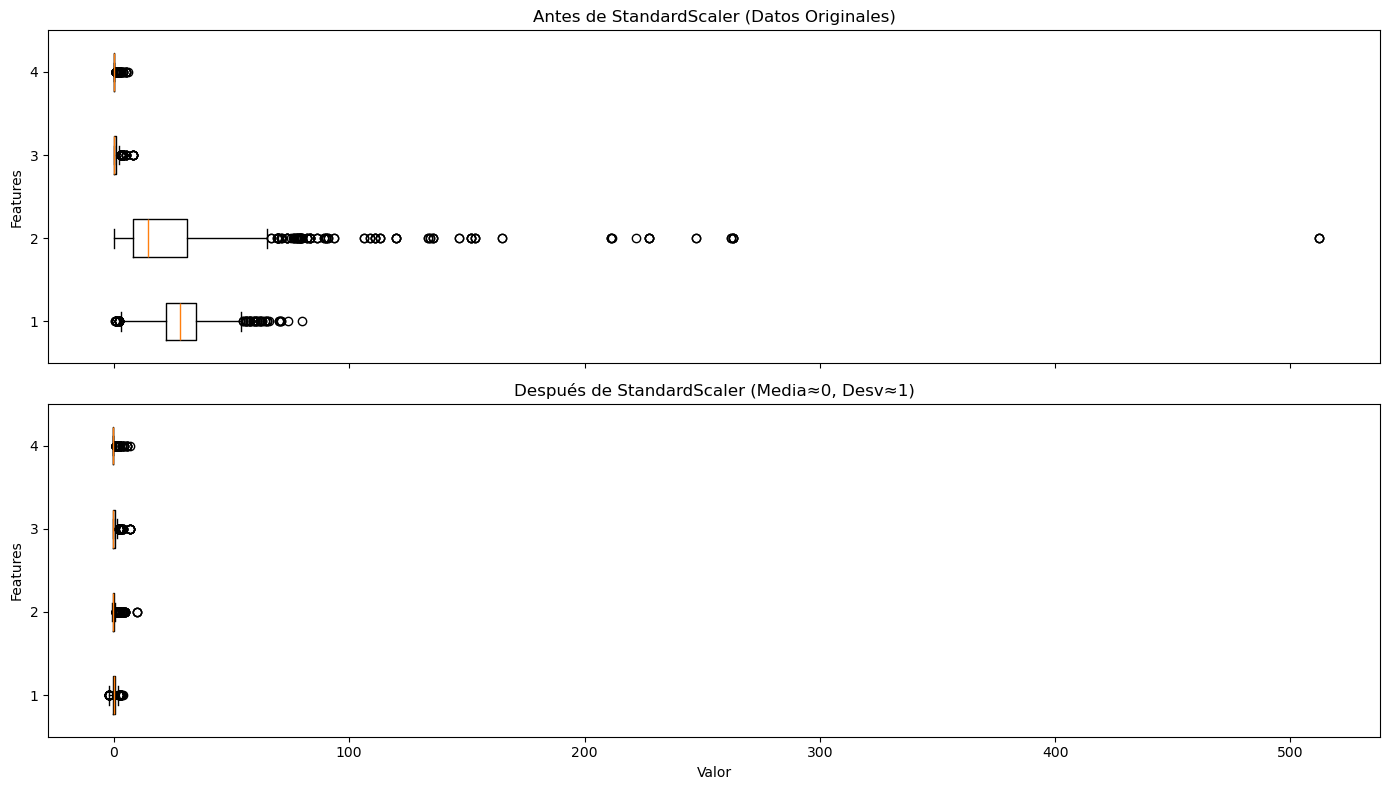

In [35]:
# Visualización efecto de StandardScaler
pdf_std = df_standard.select("features_raw", "features_standard").toPandas()

raw = pd.DataFrame(pdf_std["features_raw"].tolist(), columns=numeric_features)
std = pd.DataFrame(pdf_std["features_standard"].tolist(), columns=numeric_features)

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Antes
axes[0].boxplot(raw, vert=False)
axes[0].set_title("Antes de StandardScaler (Datos Originales)")
axes[0].set_ylabel("Features")

# Después
axes[1].boxplot(std, vert=False)
axes[1].set_title("Después de StandardScaler (Media≈0, Desv≈1)")
axes[1].set_xlabel("Valor")
axes[1].set_ylabel("Features")

plt.tight_layout()
plt.show()


El gráfico superior muestra escalas originales heterogéneas.
El inferior confirma centrado en 0 y dispersión homogénea tras estandarización.


In [36]:
# Mostrar estadísticas del StandardScaler
print("Media por característica:")
print(standard_scaler_model.mean)
print("\nDesviación estándar por característica:")
print(standard_scaler_model.std)

Media por característica:
[29.361582491582478,32.20420796857461,0.5230078563411902,0.3815937149270483]

Desviación estándar por característica:
[13.019696550973203,49.69342859718089,1.1027434322934322,0.8060572211299484]


### 9.4 MinMaxScaler 

Reescala los valores al rango [0,1], preservando proporciones relativas entre datos originales.








In [37]:
# Aplicar MinMaxScaler
minmax_scaler = MinMaxScaler(
    inputCol="features_raw",
    outputCol="features_minmax",
    min=0.0,
    max=1.0
)

minmax_scaler_model = minmax_scaler.fit(df_assembled)
df_minmax = minmax_scaler_model.transform(df_assembled)

print("MinMaxScaler aplicado:")
print("Transforma datos al rango [0, 1]")
print("\nComparación de valores originales vs normalizados:")
df_minmax.select("Pclass", "Sex", "features_raw", "features_minmax").show(5, truncate=False)

MinMaxScaler aplicado:
Transforma datos al rango [0, 1]

Comparación de valores originales vs normalizados:
+------+------+----------------------+---------------------------------------------------+
|Pclass|Sex   |features_raw          |features_minmax                                    |
+------+------+----------------------+---------------------------------------------------+
|3     |male  |[22.0,7.25,1.0,0.0]   |[0.2711736617240513,0.014151057562208049,0.125,0.0]|
|1     |female|[38.0,71.2833,1.0,0.0]|[0.4722292033174164,0.13913573538264068,0.125,0.0] |
|3     |female|[26.0,7.925,0.0,0.0]  |[0.32143754712239253,0.015468569817999833,0.0,0.0] |
|1     |female|[35.0,53.1,1.0,0.0]   |[0.43453128926866047,0.10364429745562033,0.125,0.0]|
|3     |male  |[35.0,8.05,0.0,0.0]   |[0.43453128926866047,0.015712553569072387,0.0,0.0] |
+------+------+----------------------+---------------------------------------------------+
only showing top 5 rows



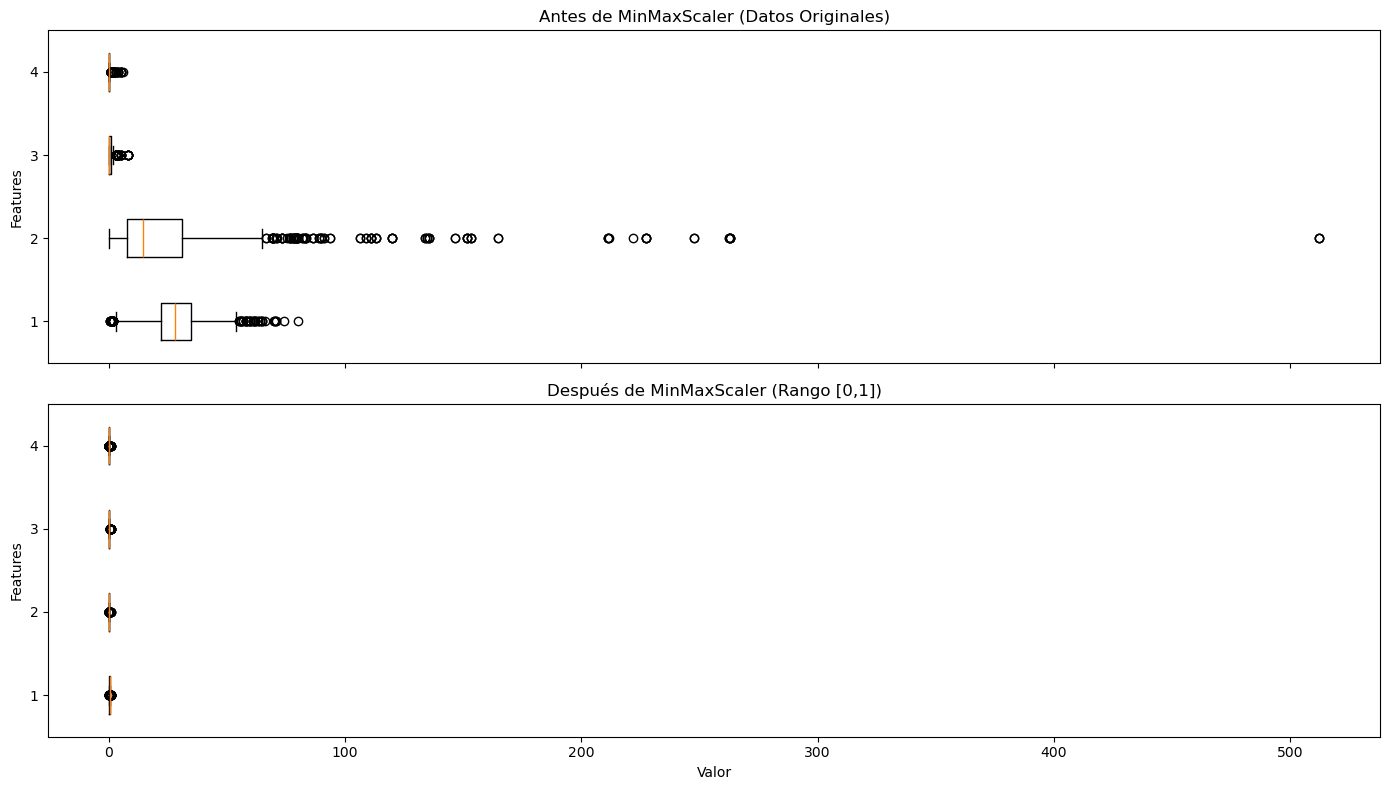

In [38]:
# Visualización efecto de MinMaxScaler
pdf_mm = df_minmax.select("features_raw", "features_minmax").toPandas()

raw = pd.DataFrame(pdf_mm["features_raw"].tolist(), columns=numeric_features)
mm = pd.DataFrame(pdf_mm["features_minmax"].tolist(), columns=numeric_features)

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Antes
axes[0].boxplot(raw, vert=False)
axes[0].set_title("Antes de MinMaxScaler (Datos Originales)")
axes[0].set_ylabel("Features")

# Después
axes[1].boxplot(mm, vert=False)
axes[1].set_title("Después de MinMaxScaler (Rango [0,1])")
axes[1].set_xlabel("Valor")
axes[1].set_ylabel("Features")

plt.tight_layout()
plt.show()


El gráfico inferior evidencia la compresión al rango [0,1].
Todos los features quedan comparables sin alterar proporciones relativas.


In [39]:
# Mostrar estadísticas del MinMaxScaler
print("Valor mínimo original por característica:")
print(minmax_scaler_model.originalMin)
print("\nValor máximo original por característica:")
print(minmax_scaler_model.originalMax)

Valor mínimo original por característica:
(4,[0],[0.42])

Valor máximo original por característica:
[80.0,512.3292,8.0,6.0]


## 10. Dataset Final Procesado

In [40]:
# Unir ambos métodos de normalización para comparación
# Usando índice monotónico como no tenemos PassengerId después de haberlo eliminado
from pyspark.sql.functions import monotonically_increasing_id

df_standard_indexed = df_standard.withColumn("row_id", monotonically_increasing_id())
df_minmax_indexed = df_minmax.withColumn("row_id", monotonically_increasing_id())

df_normalized = df_standard_indexed.join(
    df_minmax_indexed.select("row_id", "features_minmax"),
    on="row_id",
    how="inner"
)

print("Comparación de métodos de normalización:")
print("=" * 70)
df_normalized.select(
    "Pclass",
    "Sex",
    "features_raw",
    "features_standard",
    "features_minmax"
).show(5, truncate=False)

Comparación de métodos de normalización:
+------+------+----------------------+------------------------------------------------------------------------------------+-------------------------------------------------------------------+
|Pclass|Sex   |features_raw          |features_standard                                                                   |features_minmax                                                    |
+------+------+----------------------+------------------------------------------------------------------------------------+-------------------------------------------------------------------+
|3     |male  |[22.0,7.25,1.0,0.0]   |[-0.5654188991856505,-0.5021631365156048,0.4325504280418018,-0.47340772456838986]   |[0.34656948982156316,0.014110458666029575,0.0,0.0]                 |
|1     |female|[38.0,71.2833,1.0,0.0]|[0.6634883904242618,0.7864036178345389,0.4325504280418018,-0.47340772456838986]     |[0.2460417190248806,0.030725752114070404,0.125,0.16666666666666666]|

In [41]:
# Crear dataset final con todas las transformaciones
df_final = df_normalized.select(
    "Pclass",
    "Sex",
    "Age",
    "SibSp",
    "Parch",
    "Fare",
    "Embarked",
    "Survived",
    "Cabins",
    "features_standard",
    "features_minmax"
)

print("Dataset Final Procesado:")
print("=" * 70)
df_final.show(10, truncate=False)

print(f"\nTotal de registros finales: {df_final.count()}")
print(f"Total de columnas: {len(df_final.columns)}")

Dataset Final Procesado:
+------+------+----+-----+-----+-------+--------+--------+---------+------------------------------------------------------------------------------------+--------------------------------------------------------------------+
|Pclass|Sex   |Age |SibSp|Parch|Fare   |Embarked|Survived|Cabins   |features_standard                                                                   |features_minmax                                                     |
+------+------+----+-----+-----+-------+--------+--------+---------+------------------------------------------------------------------------------------+--------------------------------------------------------------------+
|3     |male  |22.0|1    |0    |7.25   |S       |0       |[Unknown]|[-0.5654188991856505,-0.5021631365156048,0.4325504280418018,-0.47340772456838986]   |[0.34656948982156316,0.014110458666029575,0.0,0.0]                  |
|1     |female|38.0|1    |0    |71.2833|C       |1       |[C85]    |[0.663488390424

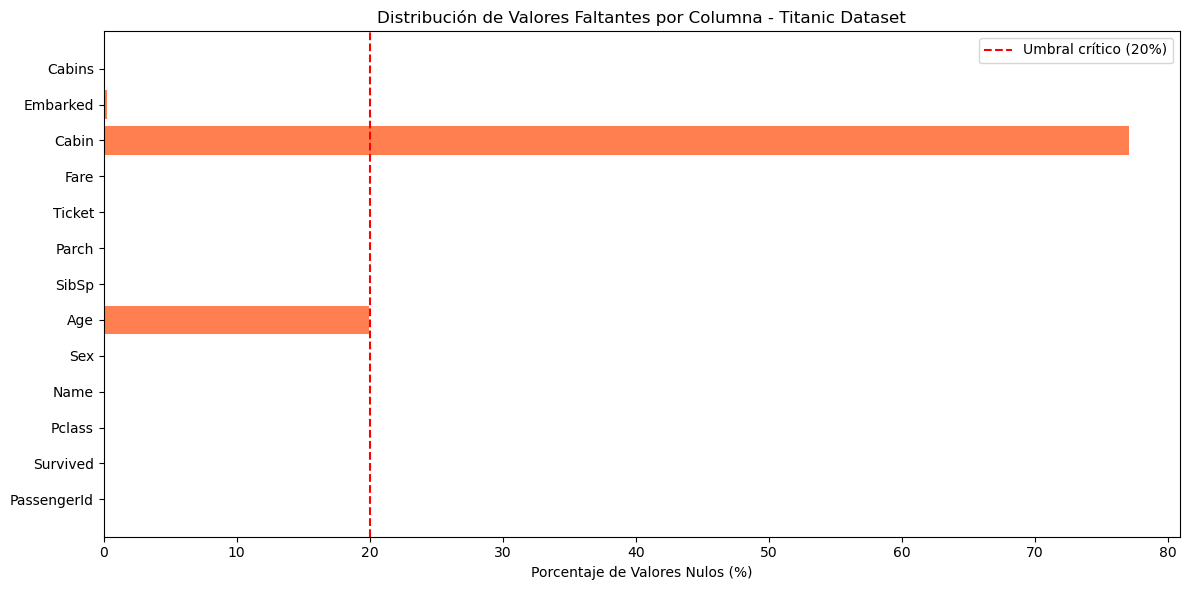

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

# Calcular porcentaje de nulos
null_data = []
for col_name in df.columns:
    null_count = df.filter(F.col(col_name).isNull()).count()
    null_percentage = (null_count / total_rows) * 100
    null_data.append({'Columna': col_name, 'Porcentaje Nulos': null_percentage})

null_df = pd.DataFrame(null_data)

# Graficar
plt.figure(figsize=(12, 6))
plt.barh(null_df['Columna'], null_df['Porcentaje Nulos'], color='coral')
plt.xlabel('Porcentaje de Valores Nulos (%)')
plt.title('Distribución de Valores Faltantes por Columna - Titanic Dataset')
plt.axvline(x=20, color='red', linestyle='--', label='Umbral crítico (20%)')
plt.legend()
plt.tight_layout()
plt.show()

Cabin supera ampliamente el **umbral del 20%**, lo que justifica su transformación o eliminación. La columna *Age*  presenta valores faltantes moderados y requiere imputación.
El resto de variables no presentan impacto crítico por nulos.


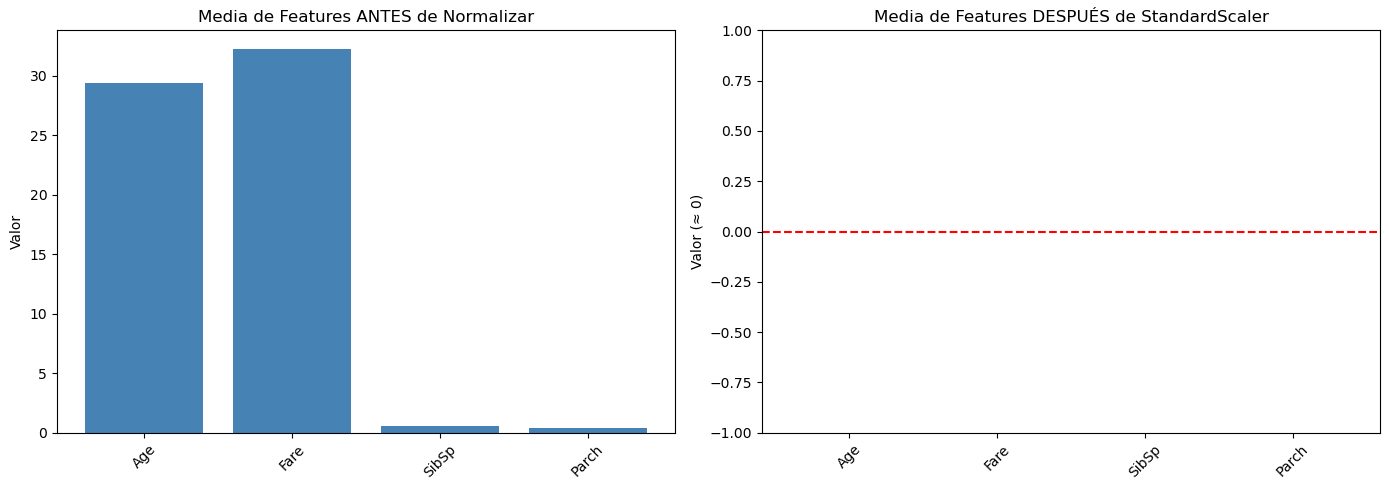

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Antes de normalizar
stats_before = df_reduced.select(numeric_features).toPandas().describe().loc['mean']
axes[0].bar(stats_before.index, stats_before.values, color='steelblue')
axes[0].set_title('Media de Features ANTES de Normalizar')
axes[0].set_ylabel('Valor')
axes[0].tick_params(axis='x', rotation=45)

# Después de normalizar (StandardScaler: media ≈ 0)
axes[1].bar(numeric_features, [0]*len(numeric_features), color='seagreen')
axes[1].axhline(y=0, color='red', linestyle='--')
axes[1].set_title('Media de Features DESPUÉS de StandardScaler')
axes[1].set_ylabel('Valor (≈ 0)')
axes[1].set_ylim(-1, 1)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Las variables presentan escalas heterogéneas.
`Fare` y `Age` dominan en magnitud frente a SibSp y Parch, lo que puede sesgar modelos posteriores.

*Todas las variables quedan centradas alrededor de 0.*
Se elimina la dominancia por escala y se homogeneizan magnitudes entre variables.


## Resumen del analisis

Con este cuaderno se demostró el uso de Spark para preprocesamiento completo de datos, siguiendo los siguientes pasos:

#### 1. Valores Faltantes

- Se identificaron nulos en Age, Fare, Embarked y Cabin.
- Se rellenaron con:
    - Mediana (Age), media (Fare).
    - Moda (Embarked).
    - "Unknown" para Cabin.
    - Resultado: dataset completo sin pérdida de filas.

#### 2. Duplicados

- Existían registros totalmente repetidos.
- Se aplicó dropDuplicates() (general y por PassengerId).
- Mejoró la calidad y redujo carga de procesamiento.

#### 3. Columnas Eliminadas

- Se removieron: Name, Ticket, Cabin original, PassengerId.
- Razones: valores únicos, formatos inconsistentes o no predictivos.
- La cabina se transformó a un array más útil para análisis.

#### 4. Transformaciones

- Explode: permitió analizar cabinas individuales.
- Pivot: facilitó análisis cruzado (Clase–Sexo, Supervivencia–Puerto, etc.) y reveló patrones demográficos.

#### 5. Normalización

- StandardScaler: útil para modelos sensibles a escala (Regresión, SVM).
- MinMaxScaler: ideal para redes neuronales; lleva todo al rango [0,1].
- Se usa porque variables como Fare tienen rangos muy diferentes.

### Conclusiones Clave

- El preprocesamiento es esencial para interpretar datos del Titanic.
- Explode y Pivot revelan patrones históricos importantes.
- La normalización evita que diferencias grandes entre variables distorsionen los modelos.
- Documentar cada paso garantiza reproducibilidad.

### Insights del Dataset

- Age tiene ~20% de valores faltantes.
- La mayoría no tenía asignada cabina.
- Clase social influye fuertemente en la supervivencia.
- Southampton fue el puerto más común.